# Image Classification using Convolutional Neural Network (CNN)
In this project, I will classify images from the CIFAR-10 dataset. The dataset consists of airplanes, dogs, cats, and other objects. I will preprocess the images, then train a convolutional neural network on all the samples. The images need to be normalized and the labels need to be one-hot encoded. Then I build a convolutional, max pooling, dropout, and fully connected layers. At the end, the neural network's predictions on the sample images is shown.

In [23]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import problem_unittests as tests
import tarfile
import helper
import numpy as np
import tensorflow.compat.v1 as tf
import random

In [2]:
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


## Download datasets

In [3]:
cifar10_dataset_folder_path = 'cifar-10-batches-py'

# Use Floyd's cifar-10 dataset if present
floyd_cifar10_location = '/input/cifar-10/python.tar.gz'
if isfile(floyd_cifar10_location):
    tar_gz_path = floyd_cifar10_location
else:
    tar_gz_path = 'cifar-10-python.tar.gz'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(tar_gz_path):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            tar_gz_path,
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open(tar_gz_path) as tar:
        tar.extractall()
        tar.close()


tests.test_folder_path(cifar10_dataset_folder_path)

All files found!


## Explore datasets

The dataset is broken into batches to prevent machine from running out of memory. 
<br>
The CIFAR-10 dataset consists of 5 batches, named data_batch_1, data_batch_2, etc.. Each batch contains the labels and images that are one of the following:
* airplane
* automobile
* bird
* cat
* deer
* dog
* frog
* horse
* ship
* truck


Stats of batch 1:
Samples: 10000
Label Counts: {0: 1005, 1: 974, 2: 1032, 3: 1016, 4: 999, 5: 937, 6: 1030, 7: 1001, 8: 1025, 9: 981}
First 20 Labels: [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6]

Example of Image 7:
Image - Min Value: 9 Max Value: 248
Image - Shape: (32, 32, 3)
Label - Label Id: 7 Name: horse


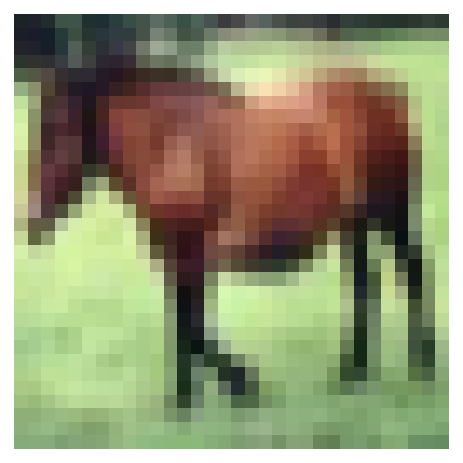

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# Explore the dataset
batch_id = 1
sample_id = 7
helper.display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

## Data Processing
### Normalization

In the cell below, implement the normalize function to take in image data, x, and return it as a normalized Numpy array. The values should be in the range of 0 to 1, inclusive. The return object should be the same shape as x.

In [5]:
def normalize(x):  
    """
    Normalize a list of sample image data in the range of 0 to 1
    : x: List of image data.  The image shape is (32, 32, 3)
    : return: Numpy array of normalize data
    """
    normalized = (x-np.min(x))/(np.max(x)-np.min(x))
    return normalized

tests.test_normalize(normalize)

Tests Passed


### One-hot encoding

The input, x, are a list of labels. Implement the function to return the list of labels as One-Hot encoded Numpy array. The possible values for labels are 0 to 9. The one-hot encoding function should return the same encoding for each value between each call to one_hot_encode. 

In [6]:
def one_hot_encode(x):
    """
    One hot encode a list of sample labels. Return a one-hot encoded vector for each label.
    : x: List of sample Labels
    : return: Numpy array of one-hot encoded labels
    """
    return np.eye(10)[x]

tests.test_one_hot_encode(one_hot_encode)

Tests Passed


### Preprocess all the data and save

In [7]:
# Preprocess Training, Validation, and Testing Data
helper.preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

Below I save it to pickle, so that if I ever have to restart the notebook, I can start from here. The preprocessed data has been saved to disk.

In [8]:
import pickle
import problem_unittests as tests
import helper

# Load the Preprocessed Validation data
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

## Build Neural Network

### Input
The neural network needs to read the image data, one-hot encoded labels, and dropout keep probability. Implement the following functions

* Implement neural_net_image_input
    - Return a TF Placeholder
    - Set the shape using image_shape with batch size set to None.
    - Name the TensorFlow placeholder "x" using the TensorFlow name parameter in the TF Placeholder.
* Implement neural_net_label_input
    - Return a TF Placeholder
    - Set the shape using n_classes with batch size set to None.
    - Name the TensorFlow placeholder "y" using the TensorFlow name parameter in the TF Placeholder.
* Implement neural_net_keep_prob_input
    - Return a TF Placeholder for dropout keep probability.
    - Name the TensorFlow placeholder "keep_prob" using the TensorFlow name parameter in the TF Placeholder.
<br>
These names will be used at the end of the project to load your saved model.

In [9]:
def neural_net_image_input(image_shape):
    """
    Return a Tensor for a bach of image input
    : image_shape: Shape of the images
    : return: Tensor for image input.
    """
    return tf.placeholder(tf.float32, shape=(None, *image_shape), name='x')


def neural_net_label_input(n_classes):
    """
    Return a Tensor for a batch of label input
    : n_classes: Number of classes
    : return: Tensor for label input.
    """
    return tf.placeholder(tf.float32, shape=(None, n_classes), name='y')


def neural_net_keep_prob_input():
    """
    Return a Tensor for keep probability
    : return: Tensor for keep probability.
    """
    return tf.placeholder(tf.float32, name='keep_prob')

tf.reset_default_graph()
tests.test_nn_image_inputs(neural_net_image_input)
tests.test_nn_label_inputs(neural_net_label_input)
tests.test_nn_keep_prob_inputs(neural_net_keep_prob_input)

Image Input Tests Passed.
Label Input Tests Passed.
Keep Prob Tests Passed.


### Convolution and Max Pooling Layer
Convolution layers have a lot of success with images. For this code cell, I implement the function conv2d_maxpool to apply convolution then max pooling:

* Create the weight and bias using conv_ksize, conv_num_outputs and the shape of x_tensor.
* Apply a convolution to x_tensor using weight and conv_strides.
    * I use same padding, but can actually use any padding.
* Add bias
* Add a nonlinear activation to the convolution.
* Apply Max Pooling using pool_ksize and pool_strides.

In [10]:
def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, 
                   pool_ksize, pool_strides):
    """
    Apply convolution then max pooling to x_tensor
    :param x_tensor: TensorFlow Tensor
    :param conv_num_outputs: Number of outputs for the convolutional layer
    :param conv_ksize: kernal size 2-D Tuple for the convolutional layer
    :param conv_strides: Stride 2-D Tuple for convolution
    :param pool_ksize: kernal size 2-D Tuple for pool
    :param pool_strides: Stride 2-D Tuple for pool
    : return: A tensor that represents convolution and max pooling of x_tensor
    """
    
    
    #Define weight
    weight_shape = [*conv_ksize, int(x_tensor.shape[3]), conv_num_outputs]
    w = tf.Variable(tf.random_normal(weight_shape, stddev=0.1))
    
    #Define bias
    b = tf.Variable(tf.zeros(conv_num_outputs))
    
    #Apply convolution
    x = tf.nn.conv2d(x_tensor, w, strides=[1, *conv_strides, 1], padding='SAME')
    
    #Apply bias
    x = tf.nn.bias_add(x, b)
    
    #Apply RELU
    x = tf.nn.relu(x)
    
    #Apply Max pool
    x = tf.nn.max_pool(x, [1, *pool_ksize, 1], [1, *pool_strides, 1], padding='SAME')
    return x

tests.test_con_pool(conv2d_maxpool)

Tests Passed


### Flatten Layer
Implement the flatten function to change the dimension of x_tensor from a 4-D tensor to a 2-D tensor. The output should be the shape (Batch Size, Flattened Image Size).

In [11]:
def flatten(x_tensor):
    """
    Flatten x_tensor to (Batch Size, Flattened Image Size)
    : x_tensor: A tensor of size (Batch Size, ...), where ... are the image dimensions.
    : return: A tensor of size (Batch Size, Flattened Image Size).
    """
    # Implement Function
    batch_size, *fltn_img_size = x_tensor.get_shape().as_list()
    img_size = fltn_img_size[0] * fltn_img_size[1] * fltn_img_size[2]
    tensor = tf.reshape(x_tensor, [-1, img_size])
    return tensor

tests.test_flatten(flatten)

Tests Passed


### Fully-Connected Layer
Implement the fully_conn function to apply a fully connected layer to x_tensor with the shape (Batch Size, num_outputs).

In [12]:
def fully_conn(x_tensor, num_outputs):

    """
    Apply a fully connected layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    #Implement Function weights
    w_shape = (int(x_tensor.get_shape().as_list()[1]), num_outputs)
    weights = tf.Variable(tf.random_normal(w_shape, stddev=0.1))
    
    #bias
    bias = tf.Variable(tf.zeros(num_outputs))
    x = tf.add(tf.matmul(x_tensor, weights), bias)
    output = tf.nn.relu(x)
    return output
    
tests.test_fully_conn(fully_conn)

Tests Passed


### Output Layer
Implement the output function to apply a fully connected layer to x_tensor with the shape (Batch Size, num_outputs).

In [13]:
def output(x_tensor, num_outputs):
    """
    Apply a output layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    #Implement Function weights
    w_shape = (int(x_tensor.get_shape().as_list()[1]), num_outputs)
    weights = tf.Variable(tf.random_normal(w_shape, stddev=0.1))
    
    #bias
    bias = tf.Variable(tf.zeros(num_outputs))
    x = tf.add(tf.matmul(x_tensor, weights), bias)
    return x

tests.test_output(output)

Tests Passed


## Create Convolutional Model
Implement the function conv_net to create a convolutional neural network model. The function takes in a batch of images, x, and outputs logits. Use the layers created above to create this model:

* Apply 1, 2, or 3 Convolution and Max Pool layers
* Apply a Flatten Layer
* Apply 1, 2, or 3 Fully Connected Layers
* Apply an Output Layer
* Return the output
* Apply TensorFlow's Dropout to one or more layers in the model using keep_prob.

In [14]:
def conv_net(x, keep_prob):
    """
    Create a convolutional neural network model
    : x: Placeholder tensor that holds image data.
    : keep_prob: Placeholder tensor that hold dropout keep probability.
    : return: Tensor that represents logits
    """
    # Apply 1, 2, or 3 Convolution and Max Pool layers
    x = conv2d_maxpool(x, 32, (3, 3), (1, 1), (2, 2), (2, 2))
    x = conv2d_maxpool(x, 32, (3, 3), (2, 2), (2, 2), (2, 2))
    x = conv2d_maxpool(x, 64, (3, 3), (1, 1), (2, 2), (2, 2))
    
    # Apply a Flatten Layer
    # Function Definition from Above:
    x = flatten(x)
    
    # Apply 1, 2, or 3 Fully Connected Layers
    #    Play around with different number of outputs
    # Function Definition from Above:
    #   fully_conn(x_tensor, num_outputs)
    x = fully_conn(x, 128)
    x = tf.nn.dropout(x, keep_prob)
    
    
    # Apply an Output Layer
    #    Set this to the number of classes
    # Function Definition from Above:
    #   output(x_tensor, num_outputs)
    result = output(x, 10)
    
    
    # return output
    return result

##############################
## Build the Neural Network ##
##############################

# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
x = neural_net_image_input((32, 32, 3))
y = neural_net_label_input(10)
keep_prob = neural_net_keep_prob_input()

# Model
logits = conv_net(x, keep_prob)

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

tests.test_conv_net(conv_net)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Neural Network Built!


## Train the Neural Network
### Single Optimization
Implement the function train_neural_network to do a single optimization. The optimization should use optimizer to optimize in session with a feed_dict of the following:

* x for image input
* y for labels
* keep_prob for keep probability for dropout
<br>
This function will be called for each batch, so tf.global_variables_initializer() has already been called.

In [15]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    """
    Optimize the session on a batch of images and labels
    : session: Current TensorFlow session
    : optimizer: TensorFlow optimizer function
    : keep_probability: keep probability
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    """
    #Implement Function
    session.run(optimizer, feed_dict={
        x: feature_batch,
        y: label_batch,
        keep_prob: keep_probability
    })

tests.test_train_nn(train_neural_network)

Tests Passed


## Show Stats
Implement the function print_stats to print loss and validation accuracy. Use the global variables valid_features and valid_labels to calculate validation accuracy. Use a keep probability of 1.0 to calculate the loss and validation accuracy.

In [16]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    """
    Print information about loss and validation accuracy
    : session: Current TensorFlow session
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    : cost: TensorFlow cost function
    : accuracy: TensorFlow accuracy function
    """
     #Implement Function
    loss = session.run(cost, feed_dict={
        x: feature_batch,
        y: label_batch,
        keep_prob: 1.
    })
    
    valid_accuracy = session.run(accuracy, feed_dict={
        x: valid_features,
        y: valid_labels,
        keep_prob: 1.
    })

    print('Loss: {:>10.4f} Validation Accuracy: {:.6f}'.format(loss, valid_accuracy))

## Hyperparameters
Tune the following parameters:

* Set epochs to the number of iterations until the network stops learning or start overfitting
* Set batch_size to the highest number that your machine has memory for. Most people set them to common sizes of memory:
    * 64
    * 128
    * 256
    * ...
<br>
* Set keep_probability to the probability of keeping a node using dropout

In [17]:
#Tune Parameters
epochs = 52
batch_size = 256
keep_probability = 0.6

## Train on a Single CIFAR-10 Batch
Instead of training the neural network on all batches of data, I will first use a single batch. This should save time while you iterate on the model to get a better accuracy. Once the final validation accuracy is 50% or greater, run the model on all the data in the next section.

In [18]:
print('Checking the Training on a Single Batch...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        batch_i = 1
        for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
            train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
        print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
        print_stats(sess, batch_features, batch_labels, cost, accuracy)

Checking the Training on a Single Batch...
Epoch  1, CIFAR-10 Batch 1:  Loss:     2.2223 Validation Accuracy: 0.276000
Epoch  2, CIFAR-10 Batch 1:  Loss:     2.0599 Validation Accuracy: 0.357600
Epoch  3, CIFAR-10 Batch 1:  Loss:     1.8633 Validation Accuracy: 0.402800
Epoch  4, CIFAR-10 Batch 1:  Loss:     1.7234 Validation Accuracy: 0.425400
Epoch  5, CIFAR-10 Batch 1:  Loss:     1.5858 Validation Accuracy: 0.441000
Epoch  6, CIFAR-10 Batch 1:  Loss:     1.4941 Validation Accuracy: 0.458000
Epoch  7, CIFAR-10 Batch 1:  Loss:     1.4146 Validation Accuracy: 0.446000
Epoch  8, CIFAR-10 Batch 1:  Loss:     1.2984 Validation Accuracy: 0.476600
Epoch  9, CIFAR-10 Batch 1:  Loss:     1.2230 Validation Accuracy: 0.485400
Epoch 10, CIFAR-10 Batch 1:  Loss:     1.1256 Validation Accuracy: 0.493000
Epoch 11, CIFAR-10 Batch 1:  Loss:     1.0205 Validation Accuracy: 0.507200
Epoch 12, CIFAR-10 Batch 1:  Loss:     0.9584 Validation Accuracy: 0.508600
Epoch 13, CIFAR-10 Batch 1:  Loss:     0.8996

## Fully Train the Model
Now that I got a good accuracy with a single batch, try it with all five batches.

In [19]:
save_model_path = './image_classification'

print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...
Epoch  1, CIFAR-10 Batch 1:  Loss:     2.1433 Validation Accuracy: 0.286000
Epoch  1, CIFAR-10 Batch 2:  Loss:     1.8434 Validation Accuracy: 0.338200
Epoch  1, CIFAR-10 Batch 3:  Loss:     1.5547 Validation Accuracy: 0.369600
Epoch  1, CIFAR-10 Batch 4:  Loss:     1.6057 Validation Accuracy: 0.425800
Epoch  1, CIFAR-10 Batch 5:  Loss:     1.5083 Validation Accuracy: 0.443000
Epoch  2, CIFAR-10 Batch 1:  Loss:     1.6450 Validation Accuracy: 0.465200
Epoch  2, CIFAR-10 Batch 2:  Loss:     1.3953 Validation Accuracy: 0.470400
Epoch  2, CIFAR-10 Batch 3:  Loss:     1.2641 Validation Accuracy: 0.461800
Epoch  2, CIFAR-10 Batch 4:  Loss:     1.3548 Validation Accuracy: 0.486400
Epoch  2, CIFAR-10 Batch 5:  Loss:     1.2802 Validation Accuracy: 0.503000
Epoch  3, CIFAR-10 Batch 1:  Loss:     1.4174 Validation Accuracy: 0.513400
Epoch  3, CIFAR-10 Batch 2:  Loss:     1.2375 Validation Accuracy: 0.521800
Epoch  3, CIFAR-10 Batch 3:  Loss:     1.1411 Validation Accuracy: 0.483400


Epoch 22, CIFAR-10 Batch 4:  Loss:     0.3426 Validation Accuracy: 0.667400
Epoch 22, CIFAR-10 Batch 5:  Loss:     0.3000 Validation Accuracy: 0.675800
Epoch 23, CIFAR-10 Batch 1:  Loss:     0.3704 Validation Accuracy: 0.661400
Epoch 23, CIFAR-10 Batch 2:  Loss:     0.2935 Validation Accuracy: 0.675400
Epoch 23, CIFAR-10 Batch 3:  Loss:     0.2051 Validation Accuracy: 0.685000
Epoch 23, CIFAR-10 Batch 4:  Loss:     0.3229 Validation Accuracy: 0.670200
Epoch 23, CIFAR-10 Batch 5:  Loss:     0.3057 Validation Accuracy: 0.674800
Epoch 24, CIFAR-10 Batch 1:  Loss:     0.3760 Validation Accuracy: 0.677000
Epoch 24, CIFAR-10 Batch 2:  Loss:     0.2698 Validation Accuracy: 0.674800
Epoch 24, CIFAR-10 Batch 3:  Loss:     0.2315 Validation Accuracy: 0.681400
Epoch 24, CIFAR-10 Batch 4:  Loss:     0.2950 Validation Accuracy: 0.675800
Epoch 24, CIFAR-10 Batch 5:  Loss:     0.2765 Validation Accuracy: 0.674600
Epoch 25, CIFAR-10 Batch 1:  Loss:     0.3656 Validation Accuracy: 0.666800
Epoch 25, CI

Epoch 44, CIFAR-10 Batch 2:  Loss:     0.1338 Validation Accuracy: 0.680400
Epoch 44, CIFAR-10 Batch 3:  Loss:     0.1027 Validation Accuracy: 0.674400
Epoch 44, CIFAR-10 Batch 4:  Loss:     0.1259 Validation Accuracy: 0.697400
Epoch 44, CIFAR-10 Batch 5:  Loss:     0.1290 Validation Accuracy: 0.689400
Epoch 45, CIFAR-10 Batch 1:  Loss:     0.1564 Validation Accuracy: 0.694000
Epoch 45, CIFAR-10 Batch 2:  Loss:     0.1390 Validation Accuracy: 0.678200
Epoch 45, CIFAR-10 Batch 3:  Loss:     0.1149 Validation Accuracy: 0.679600
Epoch 45, CIFAR-10 Batch 4:  Loss:     0.1287 Validation Accuracy: 0.687800
Epoch 45, CIFAR-10 Batch 5:  Loss:     0.1282 Validation Accuracy: 0.687400
Epoch 46, CIFAR-10 Batch 1:  Loss:     0.1772 Validation Accuracy: 0.680800
Epoch 46, CIFAR-10 Batch 2:  Loss:     0.1313 Validation Accuracy: 0.668800
Epoch 46, CIFAR-10 Batch 3:  Loss:     0.1169 Validation Accuracy: 0.673200
Epoch 46, CIFAR-10 Batch 4:  Loss:     0.1066 Validation Accuracy: 0.691200
Epoch 46, CI

## Test Model
Test model against the test dataset and check out the final accuracy.

INFO:tensorflow:Restoring parameters from ./image_classification
Testing Accuracy: 0.68447265625



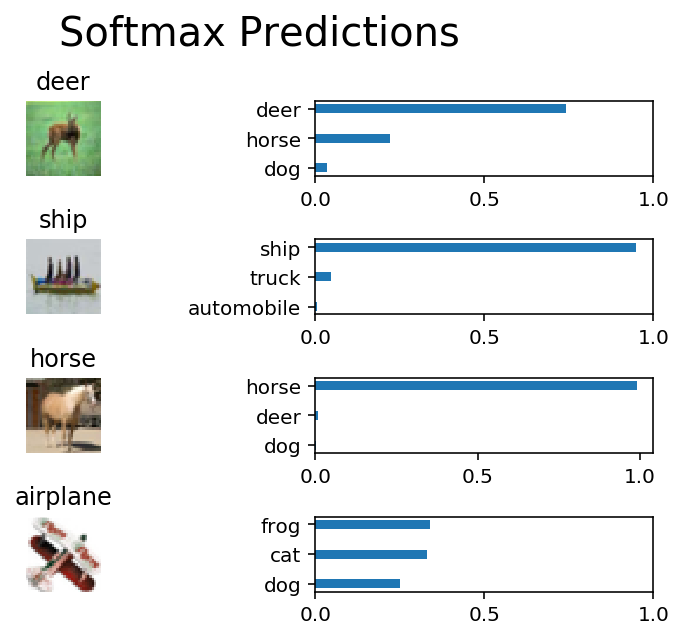

In [24]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# Set batch size if not already set
try:
    if batch_size:
        pass
except NameError:
    batch_size = 64

save_model_path = './image_classification'
n_samples = 4
top_n_predictions = 3
def test_model():
    """
    Test the saved model against the test dataset
    """

    test_features, test_labels = pickle.load(open('preprocess_training.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for train_feature_batch, train_label_batch in helper.batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: train_feature_batch, loaded_y: train_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        helper.display_image_predictions(random_test_features, random_test_labels, random_test_predictions)


test_model()